# La régression logistique

## Pourquoi la régression logistique ?

La régression logistique est un __modèle linéaire généralisé__ qui permet de répondre au cas où la variable dépendante (celle qu'on cherche à expliquer) est qualitative. Les variables explicatives (ou indépendantes) peuvent être quantitative ou qualitative.  
Il existe trois types de régressions logistiques :
- la régression logistique ordinaire ou régression logistique binaire lorsque la variable d’intérêt est binaire (oui/non, vrai/faux)
- la régression logistique multinomiale qui est une extension aux variables qualitatives à trois modalités ou plus
- la régression logistique ordinale qui correspond au cas où la variable qualitative au moins 3 modalités ordonnées hiérarchiquement

Exemples de problèmes :
- déterminer si un objet est défectueux en fonction par exemple du matériau utilisé, de la température de fabrication, de l'humidité, etc...
- déterminer si un client a cliqué sur l'offre promotionnelle contenue dans un email selon différentes caractéristiques individuelles (âge, sexe, urbain/rural, etc...).Plus généralement les problèmes de segmentation de clients
- déterminer si un email est un SPAM ou non
- en médicine : déterminer si une tumeur est maligne/bénine, si un médicament permet la guérison ou non, etc...

$\Rightarrow$ ce sont des problèmes de __classification__

## Intuition de la régression logistique

### Importer et afficher les données email_offer.csv

In [1]:
import pandas as pd
data = pd.read_csv('Data/email_offer.csv')
data.head()

,Age,Gender,TookAction
0,38,Female,0
1,32,Female,0
2,46,Male,1
3,34,Male,0
4,40,Male,0


### Tracer le scatter plot de y (TookAction) en fonction de x (Age)

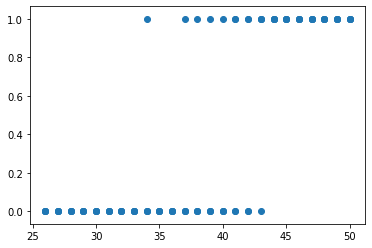

In [2]:
import matplotlib.pyplot as plt
plt.scatter(data.Age,data.TookAction);

### Entrainer un modèle de régression linéaire et afficher la droite de régression sur le scatter plot

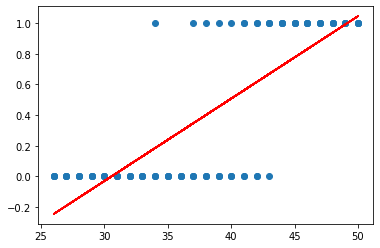

In [3]:
# Les données
x = data['Age'].values.reshape(-1,1)
y = data['TookAction']

# Construction du modèle
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x,y)

# Visualisation
plt.scatter(x,y)
plt.plot(x,model.predict(x),c='red')
plt.show()

### Coder la fonction sigmoïde et afficher son graphe

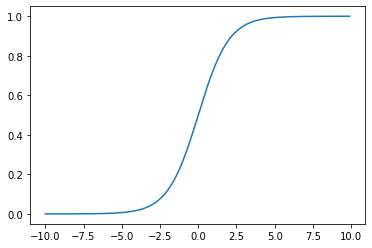

In [4]:
import numpy as np
from math import exp
sig = lambda x : 1/(1+exp(-x))

x_values = np.arange(-10,10,0.1)
    
plt.plot(x_values,list(map(sig,x_values)))
plt.show()

## Une première régression logistique

### Construire un premier modèle de régression logistique avec uniquement l'âge comme variable explicative

In [5]:
x = data['Age'].values.reshape(-1,1)
y = data['TookAction']

# Modèle de régression logistique
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression(solver='lbfgs', multi_class='auto',random_state = 0)
reg_log.fit(x, y)

# Prédictions des probabilités
prob_pred = reg_log.predict_proba(x)

# Prédictions des résultats du Test set
y_pred = reg_log.predict(x)

# Matrice de confusion
from sklearn.metrics import confusion_matrix
#affichage plus "joli" de la matrice de confusion
cm = pd.DataFrame(confusion_matrix(y, y_pred), columns=['prédit ' + str(_) for _ in reg_log.classes_])
cm.index = ['vrai ' + str(_) for _ in reg_log.classes_]
cm

,prédit 0,prédit 1
vrai 0,55,5
vrai 1,5,35


### Afficher sur un même graphique, le scatter plot, la droite de régression et les probabilités

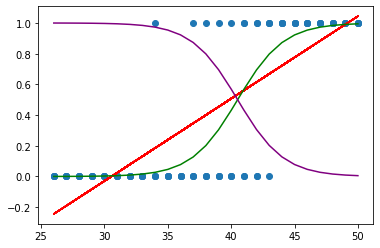

In [6]:
plt.scatter(x,y)
plt.plot(x,model.predict(x),c='red')
plt.plot(sorted(x),reg_log.predict_proba(sorted(x))[:,1],c='green')
plt.plot(sorted(x),reg_log.predict_proba(sorted(x))[:,0],c='purple')
plt.show()

### Construire un second modèle de régression logistique avec cette fois l'âge et le genre comme variables explicatives et visualiser sur les résultats sur le même graphique que précédemment

        prédit 0  prédit 1
vrai 0        57         3
vrai 1         3        37


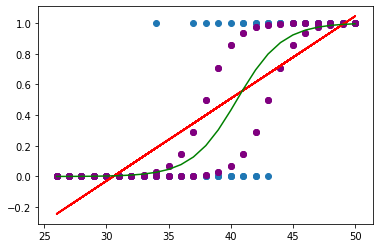

In [7]:
X = data[['Age','Gender']]
y = data['TookAction']

# Variable Genre catégorique
dummies = pd.get_dummies(X.Gender)
X = pd.concat([X,dummies], axis=1)
X.drop(['Gender','Male'],inplace=True,axis=1)

# Modèle de régression logistique sur le training set
from sklearn.linear_model import LogisticRegression
reg_log2 = LogisticRegression(solver='lbfgs', multi_class='auto', penalty ='none', random_state = 0)
reg_log2.fit(X, y)

# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y, reg_log2.predict(X)), columns=['prédit ' + str(_) for _ in reg_log2.classes_])
cm.index = ['vrai ' + str(_) for _ in reg_log2.classes_]
print(cm)

# Visualisation des probabilités prédites
plt.scatter(x,y)
plt.plot(x,model.predict(x),c='red')
plt.plot(sorted(x),reg_log.predict_proba(sorted(x))[:,1],c='green')
plt.scatter(sorted(X.Age),reg_log2.predict_proba(X.sort_values('Age'))[:,1],c='purple')
plt.show()

## Évaluation du modèle

### Matrice de confusion

In [8]:
#affichage plus "joli" de la matrice de confusion
cm = pd.DataFrame(cm, columns=['prédit ' + str(_) for _ in reg_log2.classes_])
cm.index = ['vrai ' + str(_) for _ in reg_log2.classes_]
cm

,prédit 0,prédit 1
vrai 0,57,3
vrai 1,3,37


### Affichage des probabilités

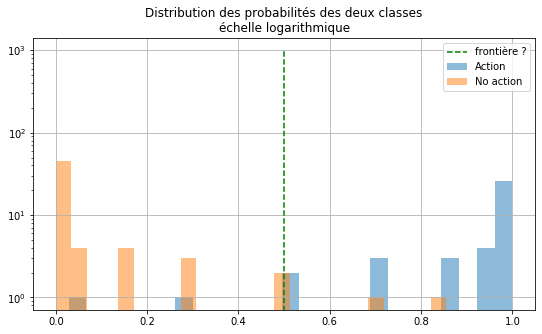

In [9]:
proba_1 = reg_log2.predict_proba(X)[:, 1]
pr = pd.DataFrame(proba_1, columns=['proba'])
pr['Action'] = y.values

fig, ax = plt.subplots(1,1,figsize=(9,5))

pr[pr.Action == 1]['proba'].hist(bins=25, label='Action', alpha=0.5, ax=ax)
pr[pr.Action == 0]['proba'].hist(bins=25, label='No action', alpha=0.5, ax=ax)
ax.plot([0.5, 0.5], [0, 1000], 'g--', label="frontière ?")
ax.set_yscale('log') #l'échelle logarithmique permet de mieux voir les probabilités qui sont faibles
ax.set_title('Distribution des probabilités des deux classes\néchelle logarithmique')
ax.legend();

### Courbe ROC et AUC

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
proba = reg_log2.predict_proba(X)
fpr0, tpr0, thresholds0 = roc_curve(y, proba[:, 0], pos_label=reg_log2.classes_[0], drop_intermediate=False)
thresholds0.shape

(51,)

In [11]:
tp = pd.DataFrame(dict(fpr=fpr0, tpr=tpr0, threshold=thresholds0))
tp.drop(0, axis=0, inplace=True) #suppression du 1er seuil fixé arbitrairement à 2

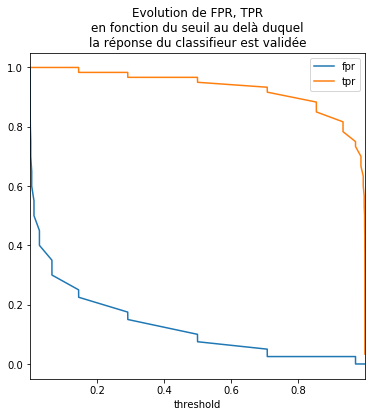

In [12]:
ax = tp.plot(x="threshold", y=['fpr', 'tpr'], figsize=(6,6))
ax.set_title("Evolution de FPR, TPR\nen fonction du seuil au delà duquel\n" + 
             "la réponse du classifieur est validée");

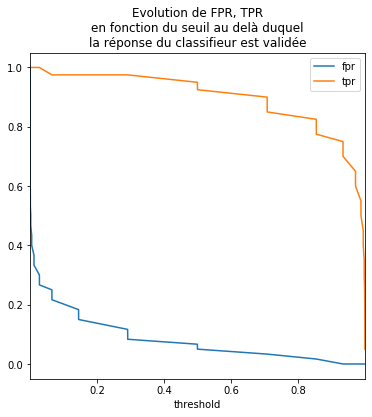

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
proba = reg_log2.predict_proba(X)
fpr1, tpr1, thresholds1 = roc_curve(y, proba[:, 1], pos_label=reg_log2.classes_[1], drop_intermediate=False)

tp = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1, threshold=thresholds1))
tp.drop(0, axis=0, inplace=True) #suppression du 1er seuil fixé arbitrairement à 2

ax = tp.plot(x="threshold", y=['fpr', 'tpr'], figsize=(6,6))
ax.set_title("Evolution de FPR, TPR\nen fonction du seuil au delà duquel\n" + 
             "la réponse du classifieur est validée");

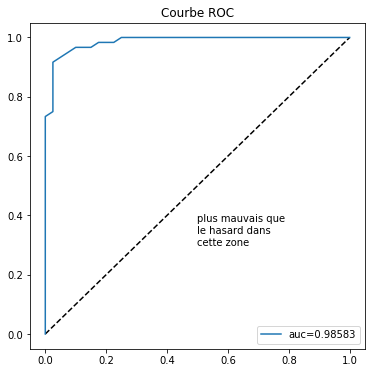

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr0, tpr0)
ax.plot(fpr0, tpr0, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC')
ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
ax.legend();

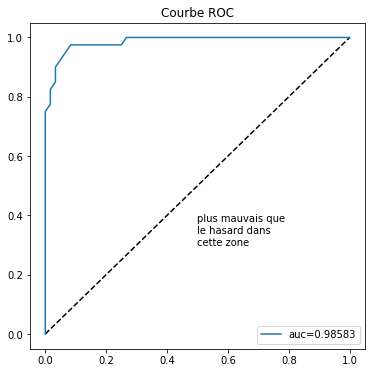

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr1, tpr1)
ax.plot(fpr1, tpr1, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC')
ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
ax.legend();

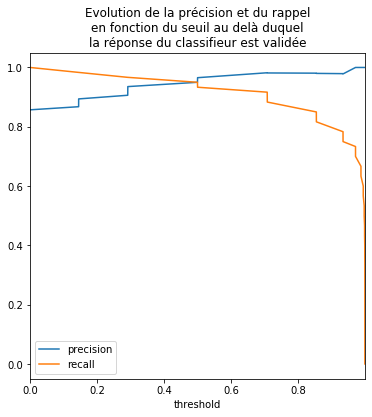

In [16]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, proba[:, 0], pos_label=reg_log2.classes_[0])

pr = pd.DataFrame(dict(precision=precision, recall=recall, 
                             threshold=[0] + list(thresholds)))

ax = pr.plot(x="threshold", y=['precision', 'recall'], figsize=(6,6))
ax.set_title("Evolution de la précision et du rappel\nen fonction du seuil au delà duquel\n" + 
             "la réponse du classifieur est validée");

## Interprétation des coefficients

In [17]:
### Affichage des coefficients obtenus avec sklearn sous forme d'un dataframe
coef = pd.DataFrame(np.concatenate([reg_log2.intercept_.reshape(-1,1), reg_log2.coef_],axis=1),
             index = ["Coefficients"],
             columns = ["constante"]+list(X.columns)).T

# Calcul de l'exponentiel pour avoir les odds-ratio
coef["OR"] = np.exp(coef.Coefficients)
coef

,Coefficients,OR
constante,-33.714578,2.280052e-15
Age,0.887226,2.428383e+00
Female,-4.437377,1.182692e-02


Interprétation :
- si on augmente l'âge d'un an, alors la probabilité de cliquer augmente 140%
- Une femme a 85 fois moins de chances de cliquer qu'un homme (1/0.0118)

In [18]:
### Construction du même modèle avec statsmodels
import statsmodels.api as sm
X = sm.add_constant(X) #rappel: par défaut statsmodel ne met pas de constante dans les modèles
reg_log3 = sm.Logit(y, X)
res = reg_log3.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.148067
         Iterations 10


/home/elka/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TookAction   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Jan 2020   Pseudo R-squ.:                  0.7800
Time:                        10:14:46   Log-Likelihood:                -14.807
converged:                       True   LL-Null:                       -67.301
Covariance Type:            nonrobust   LLR p-value:                 1.592e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.7146      8.833     -3.817      0.000     -51.027     -16.402
Age            0.8872      0.232      3.828      0.000       0.433       1.342
Female        -4.4374      1.492     -2.974      0.003      -7.361      -1.513
==============================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [19]:
#Comparaison avec le modèle où on remplace Female par Male
X = data[['Age','Gender']]
dummies = pd.get_dummies(X.Gender)
X = pd.concat([X,dummies], axis=1)
X.drop(['Gender','Female'],inplace=True,axis=1)

X = sm.add_constant(X)
reg_log4 = sm.Logit(y, X)
res = reg_log4.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.148067
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TookAction   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Jan 2020   Pseudo R-squ.:                  0.7800
Time:                        10:14:46   Log-Likelihood:                -14.807
converged:                       True   LL-Null:                       -67.301
Covariance Type:            nonrobust   LLR p-value:                 1.592e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.1520      9.987     -3.820      0.000     -57.726     -18.578
Age            0.8872      0.232      3.828      0.000       0.433       1.342
Male           4.4374      1.492      2.974      0.003       1.513       7.361
==============================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [20]:
np.exp(res.params)

const    2.696608e-17
Age      2.428383e+00
Male     8.455281e+01
dtype: float64

Interprétation : les hommes on 85 fois plus de chances de cliquer que les femmes